In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -U duckduckgo_search
!pip install fastai
!pip install fastbook


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 40.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: orjson
    Found existing installation: orjson 3.9.10
    Uninstalling orjson-3.9.10:
      Successfully uninstalled orjson-3.9.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 14.0.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 11.3 MB/s eta 0:00:00 0:00:01


In [3]:
import fastbook
fastbook.setup_book()
     

#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'e5e552a0f4a042c2b77981d24f118757')
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

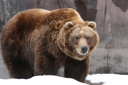

In [5]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)
     

im = Image.open(dest)
im.to_thumb(128,128)

In [6]:

bear_types = 'grizzly','black','teddy'
path = Path('bears')
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))
     

In [7]:
fns = get_image_files(path)
fns


(#423) [Path('bears/grizzly/12e56129-a74b-4577-9cc6-9a06bfe4afa9.jpg'),Path('bears/grizzly/02f79eb5-7928-4f31-b4b8-9e6432bedebf.jpg'),Path('bears/grizzly/40fc38db-2960-421c-aad3-8d77f03a18f6.jpg'),Path('bears/grizzly/2077b713-f71d-46c1-bc16-643ae809fa83.jpg'),Path('bears/grizzly/29c4d73b-a60d-42e8-bc0a-ca2f5a5862fd.jpg'),Path('bears/grizzly/4b540df1-a353-4189-82ed-ab5fa05cce5d.jpg'),Path('bears/grizzly/d0e1a418-989b-40f5-b54a-f4bc46f72a01.jpg'),Path('bears/grizzly/83612f51-67e5-479a-8037-b949757c6b98.jpg'),Path('bears/grizzly/23fe115b-d7c0-4dff-a6dd-23b16ee7c8d9.jpg'),Path('bears/grizzly/26b2e419-eade-43c8-9ba3-7ae1fc53c882.jpg')...]

In [8]:
failed = verify_images(fns)
failed
failed.map(Path.unlink);

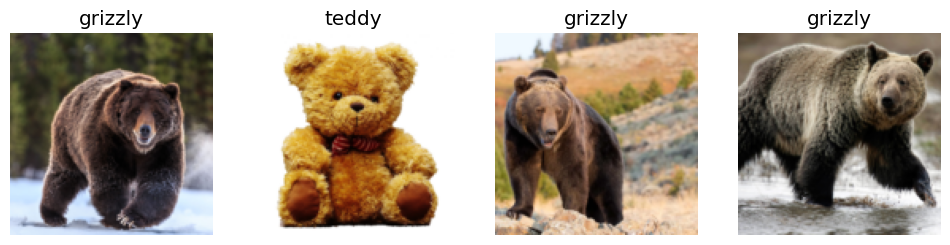

In [9]:
bears = DataBlock(
blocks=(ImageBlock, CategoryBlock),
get_items=get_image_files,
splitter=RandomSplitter(valid_pct=0.2, seed=42),
get_y=parent_label,
item_tfms=Resize(128))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

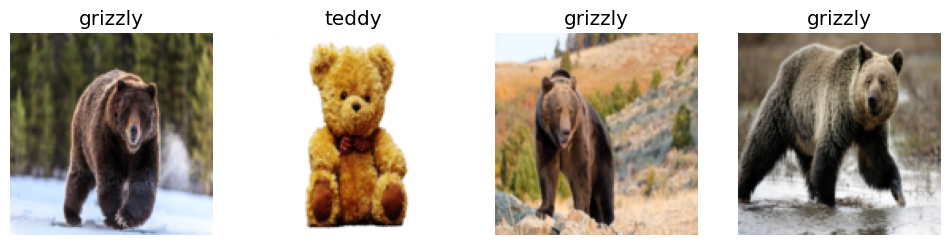

In [10]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

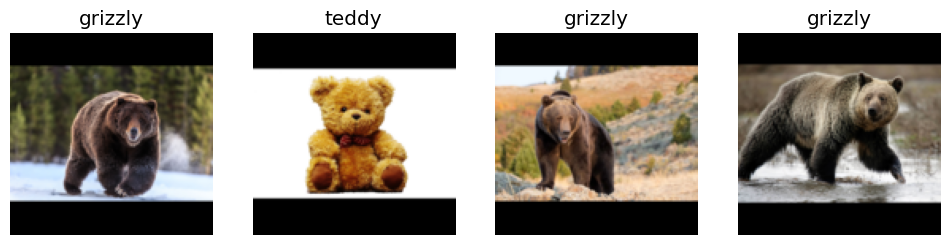

In [11]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

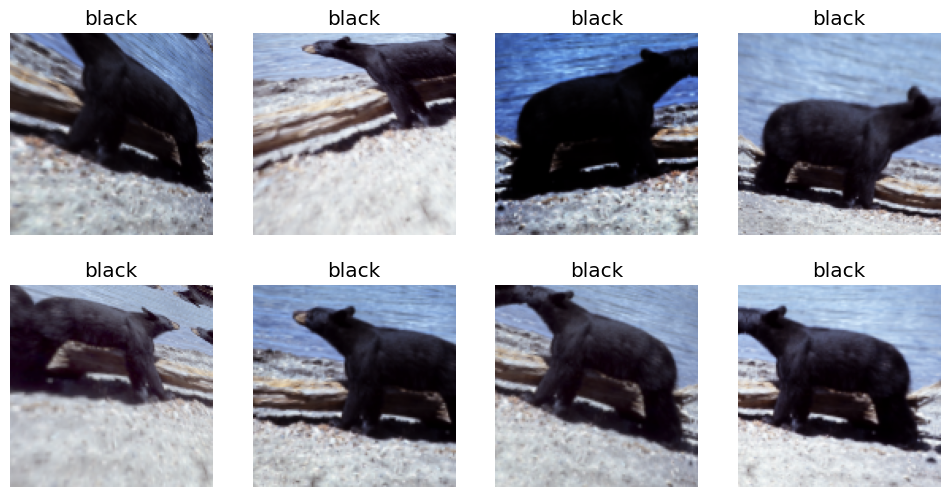

In [12]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [13]:
bears = bears.new(
        item_tfms=RandomResizedCrop(224, min_scale=0.5),
        batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [14]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.541839,0.052016,0.000000,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.221433,0.029093,0.012500,00:17
1,0.208649,0.013104,0.000000,00:17
2,0.168461,0.005383,0.000000,00:16
3,0.141205,0.005702,0.000000,00:17


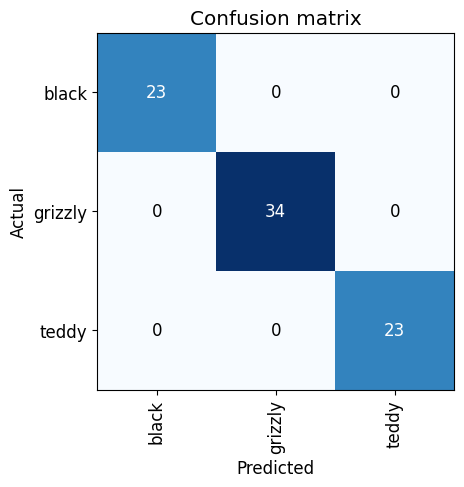

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

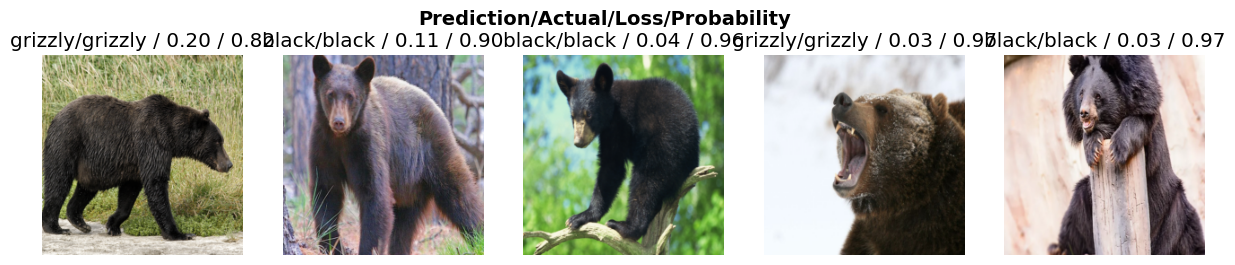

In [16]:


interp.plot_top_losses(5, nrows=1)

cleaner = ImageClassifierCleaner(learn)
cleaner


In [23]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [27]:
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict('images/grizzly.jpg')
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [28]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [30]:
img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output() 
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128)) 
out_pl


Output()

In [32]:
pred,pred_idx,probs = learn_inf.predict(img)

In [34]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9997')

In [37]:
btn_run = widgets.Button(description='Classify')
btn_run
def on_click_classify(change):
 img = PILImage.create(btn_upload.data[-1])
 out_pl.clear_output()
 with out_pl: display(img.to_thumb(128,128))
 pred,pred_idx,probs = learn_inf.predict(img)
 lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_classify)

In [38]:
VBox([widgets.Label('Select your bear!'),
          btn_upload, btn_run, out_pl, lbl_pred])

In [39]:
!pip install voila
!jupyter serverextension enable voila --sys-prefix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 29.6 MB/s eta 0:00:0000:0100:01
Config option `kernel_spec_manager_class` not recognized by `EnableServerExtensionApp`.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.5.7 OK


NameError: name 'binder' is not defined